In [1]:
import numpy as np
from genTMs import *
from matplotlib import pyplot as plt
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, normalize

In [2]:
# Generate NCIM Data According to Abilene Statistics 
TMncim, Tsparse, tm_real, mean_row, mean_col, sigmasq  = gen_NCIM()

# Transpose TMncim (n x n x T) -> (T x n x n)
TMncim_flat = TMncim.reshape(144,-1)
TMncim_flat.shape

(144, 2016)

In [4]:
TMncim.shape

(12, 12, 2016)

### Compute Averages, Non-Stationarity, and Correlation

Text(0, 0.5, 'Traffic Volume (Gbps)')

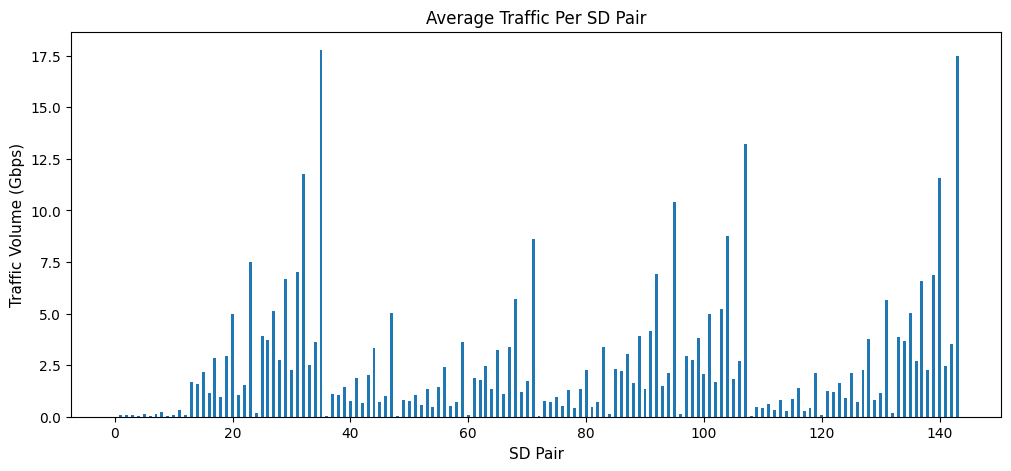

In [ ]:
average_all = np.mean(TMncim_flat, axis = 1)

fig, ax = plt.subplots(figsize = (12,5))

ax.bar(range(144), average_all, width = 0.5)
ax.set_title('Average Traffic Per SD Pair', fontsize = 12)
ax.set_xlabel('SD Pair', fontsize = 11)
ax.set_ylabel('Traffic Volume (Gbps)', fontsize = 11)

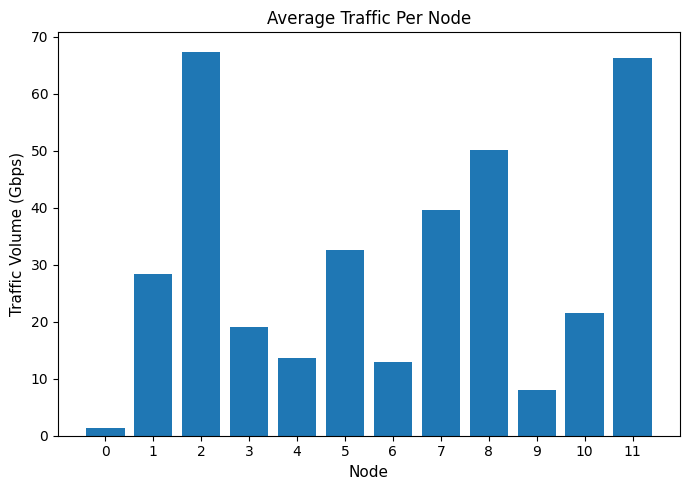

In [4]:
# Compute for a per node basis 
reshaped_data = average_all.reshape(12, 12)

# Compute the sum for each node (sum across columns for each row)
node_averages = np.sum(reshaped_data, axis=1)

node_averages.shape

fig, ax = plt.subplots(figsize = (7,5))

bar_labels = [str(number) for number in range(node_averages.shape[0])]

ax.bar(bar_labels, node_averages, width = 0.8)
ax.set_title('Average Traffic Per Node', fontsize = 12)
ax.set_xlabel('Node', fontsize = 11)
ax.set_ylabel('Traffic Volume (Gbps)', fontsize = 11)

fig.tight_layout()
#plt.savefig('Figs/average_tm_node_all.png', dpi = 600)

In [5]:
# evaluate every element in the TM for stationarity
from statsmodels.tsa.stattools import adfuller

stationary_list = []
p_values = []
for i in range(TMncim_flat.shape[0]): 
    time_series = TMncim_flat[i, :]
    
    # Perform ADF test
    result = adfuller(time_series)
    p_values.append(result[1])
    if result[1] <= 0.05:
        # series is stationary 
        stationary_list.append(True)
    else: 
        # series is not stationary
        stationary_list.append(False)

In [6]:
count_true = sum(1 for value in stationary_list if value is True)
count_false = sum(1 for value in stationary_list if value is False)

print("Number of Stationary Series:", count_true)   
print("Number of Non-Stationary Series:", count_false) 

Number of Stationary Series: 81
Number of Non-Stationary Series: 63


In [7]:
from scipy.stats import pearsonr
import itertools as it

# Feature-wise min-max normalization (normalize each element over time)
traffic_matrices= np.transpose(TMncim, (2, 0, 1))
min_vals = traffic_matrices.min(axis=0)  # Shape (12, 12)
max_vals = traffic_matrices.max(axis=0)  # Shape (12, 12)
normalized_matrices = (traffic_matrices - min_vals) / (max_vals - min_vals + 1e-8)  # Avoid division by zero

# Create combinations
source_dests = list(it.product(range(0,12), repeat = 2))
source_dests_2 = source_dests
source_dest_pairs = list(it.combinations_with_replacement(source_dests, 2))

# Compute Pearson correlation for each source over time
source_correlations = {}
pairs_1 = it.product()
for (s, d) in source_dests:
    correlations = []

    # Get the time series for the (source, dest) pair
    ts_1= normalized_matrices[:, s, d]

    for (s_1, d_1) in source_dests_2: 
        # if sources are equal
        if (s_1 == s):
            # Get the time series for the (source, dest) pair
            ts_2= normalized_matrices[:, s_1, d_1]

            # Calculate Pearson correlation for this source with all other destinations
            # Append correlations in the form (dest, correlation_value)
            correlation, _ = pearsonr(ts_1, ts_2)
            correlations.append((s_1, d_1, correlation))
    
    # Store correlations for the current source
    source_correlations[(s, d)] = correlations

In [8]:
# Remove duplicates from list for computing CDF and PDF of correlations
sources = list(range(12))
source_correlations_final = {}
for source in sources: 
    filtered_keys = [key for key in source_correlations.keys() if key[0] == source]

    used_keys = []
    corr_list = []
    for filtered_key in filtered_keys: 
        temp1 = source_correlations[filtered_key]

        for s, d, corr in temp1:
            if (s,d) not in used_keys:
                corr_list.append(corr)
            else: 
                continue


        used_keys.append(filtered_key)

    source_correlations_final[source] = corr_list

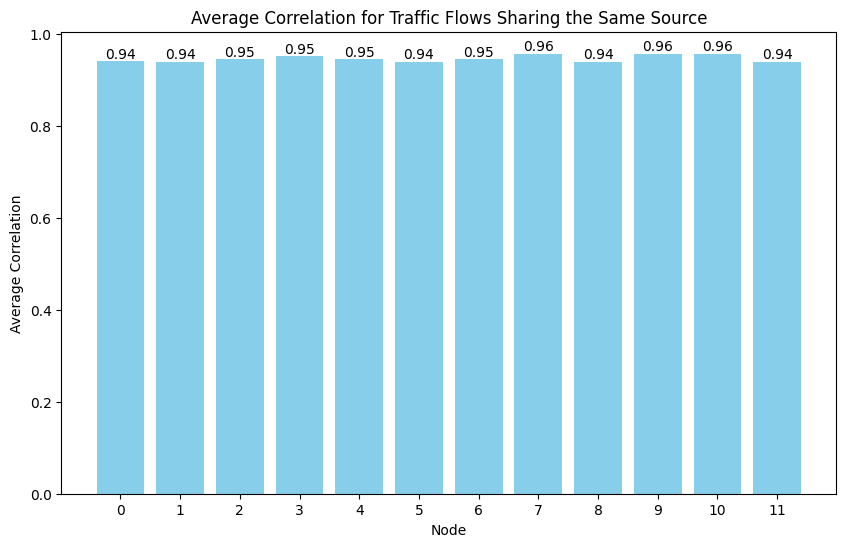

In [9]:
# Calculate the average correlation for each of the 12 lists
average_correlations = [np.mean(source_correlations_final[source]) for source in range(0,12)]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(0, 12), average_correlations, color='skyblue')
plt.bar_label(bars,  fmt='%.2f')
plt.title('Average Correlation for Traffic Flows Sharing the Same Source')
plt.xlabel('Node')
plt.ylabel('Average Correlation')
plt.xticks(range(0, 12))  # Label x-axis from 1 to 12
#plt.savefig('Figs/avg_correlation_same_source.png', dpi = 300)
plt.show()

Destination Correlations

In [10]:
# Create combinations
source_dests = list(it.product(range(0,12), repeat = 2))
source_dests_2 = source_dests
source_dest_pairs = list(it.combinations_with_replacement(source_dests, 2))

# Compute Pearson correlation for each source over time
destination_correlations = {}

for (d, s) in source_dests:
    correlations = []

    # Get the time series for the (source, dest) pair
    ts_1= normalized_matrices[:, s, d]

    for (d_1, s_1) in source_dests_2: 
        # if destinations are equal
        if (d_1 == d):
            # Get the time series for the (source, dest) pair
            ts_2= normalized_matrices[:, s_1, d_1]

            # Calculate Pearson correlation for this source with all other destinations
            # Append correlations in the form (dest, correlation_value)
            correlation, _ = pearsonr(ts_1, ts_2)
            correlations.append((s_1, d_1, correlation))
    
    # Store correlations for the current source
    destination_correlations[(d, s)] = correlations

In [11]:
# Remove duplicates from list for computing CDF and PDF of correlations
destinations = list(range(12))
dest_correlations_final = {}
for dest in destinations: 
    filtered_keys = [key for key in destination_correlations.keys() if key[0] == dest]

    used_keys = []
    corr_list = []
    for filtered_key in filtered_keys: 
        temp1 = destination_correlations[filtered_key]

        for d, s, corr in temp1:
            if (d,s) not in used_keys:
                corr_list.append(corr)
            else: 
                continue


        used_keys.append(filtered_key)

    dest_correlations_final[dest] = corr_list

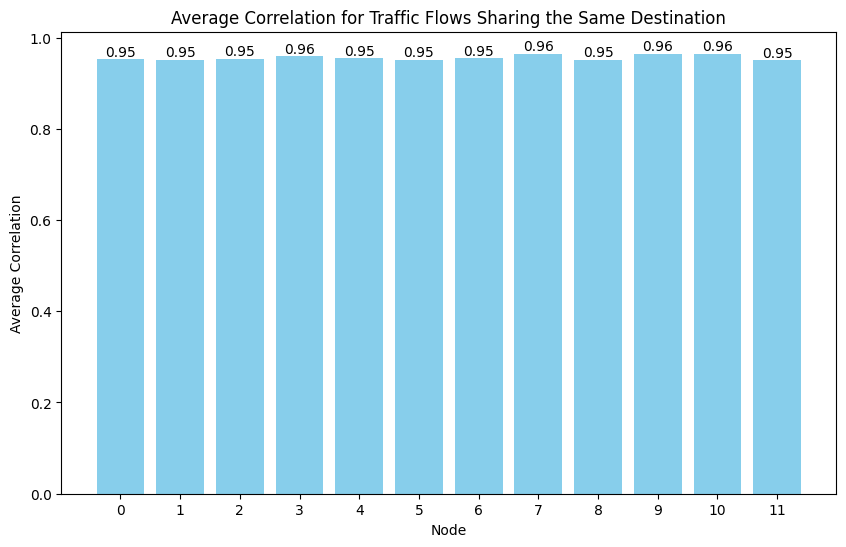

In [12]:
# Calculate the average correlation for each of the 12 lists
average_correlations = [np.mean(dest_correlations_final[dest]) for dest in range(0,12)]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(0, 12), average_correlations, color='skyblue')
plt.bar_label(bars,  fmt='%.2f')
plt.title('Average Correlation for Traffic Flows Sharing the Same Destination')
plt.xlabel('Node')
plt.ylabel('Average Correlation')
plt.xticks(range(0, 12))  # Label x-axis from 1 to 12
#plt.savefig('Figs/avg_correlation_same_dest.png', dpi = 300)
plt.show()

Correlations Not Sharing a Source or Destination

In [13]:
# Create combinations
source_dests = list(it.product(range(0,12), repeat = 2))
source_dests_2 = source_dests
source_dest_pairs = list(it.combinations_with_replacement(source_dests, 2))

# Compute Pearson correlation for each source over time
no_common_correlations = {}

for (s, d) in source_dests:
    correlations = []

    # Get the time series for the (source, dest) pair
    ts_1= normalized_matrices[:, s, d]

    for (s_1, d_1) in source_dests_2: 
        # if destinations are equal
        if (d_1 != d) & (d_1 != s) & (s_1 != s) & (s_1 != d):
            # Get the time series for the (source, dest) pair
            ts_2= normalized_matrices[:, s_1, d_1]

            # Calculate Pearson correlation for this source with all other destinations
            # Append correlations in the form (dest, correlation_value)
            correlation, _ = pearsonr(ts_1, ts_2)
            correlations.append((s_1, d_1, correlation))
    
    # Store correlations for the current source
    no_common_correlations[(s, d)] = correlations

In [14]:
# Remove duplicates from list for computing CDF and PDF of correlations
sources = list(range(0,12))
no_common_correlations_final = {}

for source in sources: 
    filtered_keys = [key for key in no_common_correlations.keys() if key[0] == source]

    used_keys = []
    corr_list = []
    for filtered_key in filtered_keys: 
        temp1 = no_common_correlations[filtered_key]

        for s, d, corr in temp1:
            corr_list.append(corr)

    no_common_correlations_final[source] = corr_list

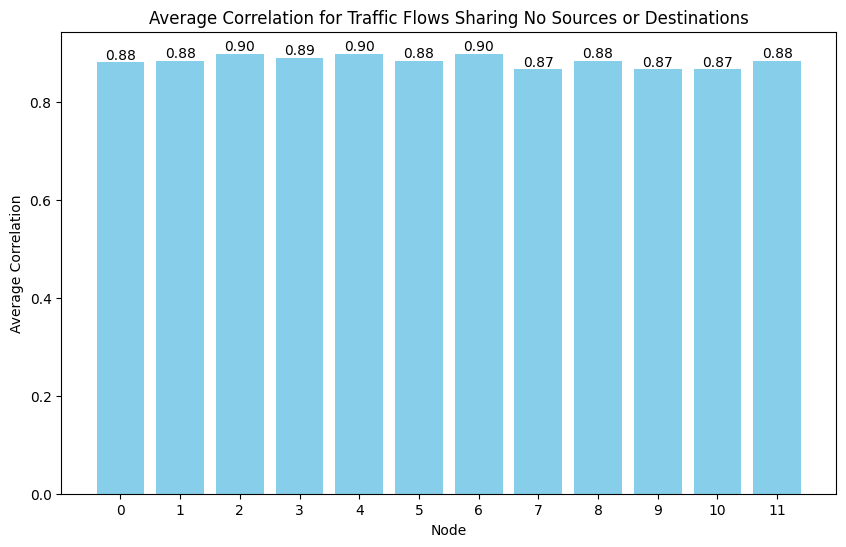

In [15]:
# Calculate the average correlation for each of the 12 lists
average_correlations = [np.mean(np.abs(no_common_correlations_final[dest])) for dest in range(0,12)]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(0, 12), average_correlations, color='skyblue')
plt.bar_label(bars,  fmt='%.2f')
plt.title('Average Correlation for Traffic Flows Sharing No Sources or Destinations')
plt.xlabel('Node')
plt.ylabel('Average Correlation')
plt.xticks(range(0, 12))  # Label x-axis from 1 to 12
#plt.savefig('Figs/avg_correlation_no_source_dest.png', dpi = 300)
plt.show()

Everything shares a strong correlation, which isn't exactly true to the Abilene data. We will see if this has any affect on the prediction performance. 

### Compare tm_real.mat data with my abilene data

In [42]:
import scipy.io

mat = scipy.io.loadmat('tm_real.mat') # dictionary
tm_real = mat['tm_real']

my_data = read_abilene_data(read_week=True, week=20)

In [43]:
my_data.shape

(2016, 144)

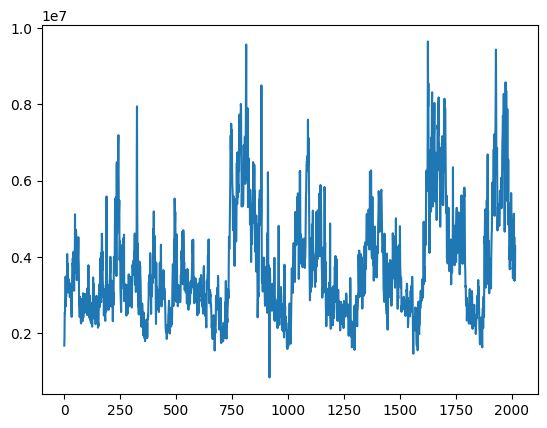

In [44]:
plt.plot(my_data[:,89])

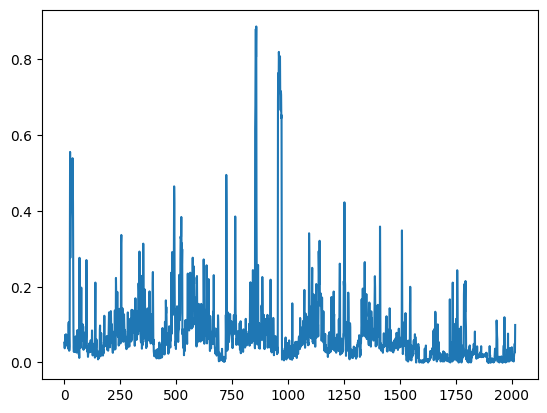

In [45]:
plt.plot(tm_real[1,:])

In [51]:
tm_real.shape

(144, 2016)

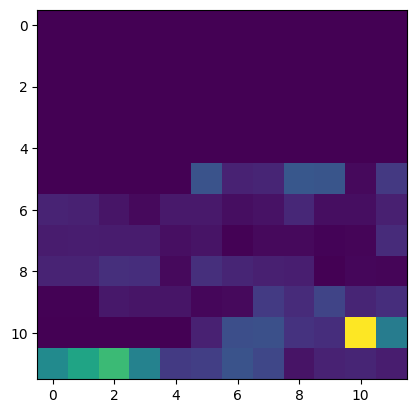

In [56]:
plt.imshow(my_data[500, :].reshape(12,12))

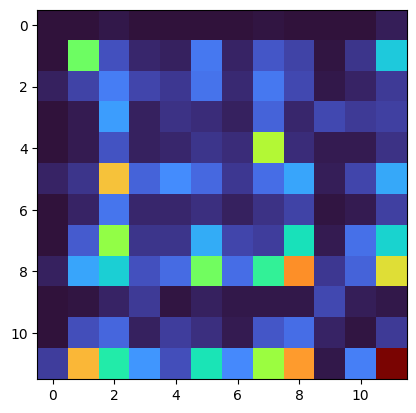

In [53]:
plt.imshow(tm_real[:, 0].reshape(12, 12), cmap='turbo')

Note, I don't know what week tm_real come from. It has been scaled by 1e6 (1Mb?) I believe. However, the noisy shapes 

### Perform TM Prediction -- NCIM with tm_real.mat

In [22]:
# Generate NCIM Data According to Abilene Statistics 
TMncim, Tsparse, tm_real, mean_row, mean_col, sigmasq  = gen_NCIM()

# Transpose TMncim (n x n x T) -> (T x n x n)
TMncim = np.transpose(TMncim, (2,0,1))
data = TMncim.reshape(-1, 144)

print(TMncim.shape)
print(data.shape)

(2016, 12, 12)
(2016, 144)


In [23]:
# Train Test Split 
train_data, test_data = train_test_split(data, 0.8)

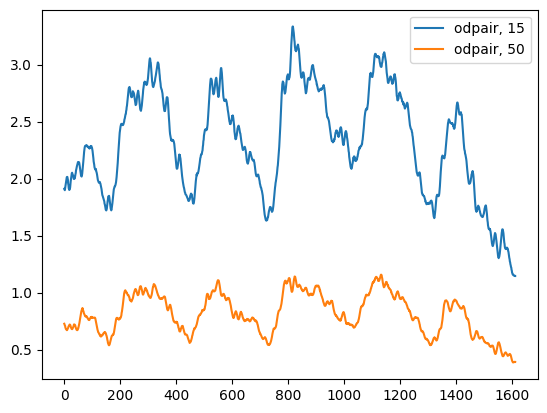

In [42]:
plt.plot(train_data[:, 15], label = 'odpair, 15')
plt.plot(train_data[:, 50], label = 'odpair, 50')
plt.legend()

In [14]:
# Min Max Normalize the train data and test data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_norm = normalize_matrix(scaler, train_data)

scaler = MinMaxScaler(feature_range=(0,1))
test_data_norm = normalize_matrix(scaler, test_data)

In [23]:
# Window the dataset 
window = 10
trainX, trainY= create_dataset(train_data_norm, window) 
testX, testY = create_dataset(test_data_norm, window) 

In [24]:
# Define hyperparameters
num_nodes = 12 
input_size = trainX.shape[2] # Number of features in input
hidden_size = 200  # Number of features in hidden state
learn_rate = 0.001 
epochs = 100
num_layers = 1
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [25]:
# Create training dataset and dataloader
train_loader = get_dataloader(trainX, trainY, batch_size, num_workers, shuffle)
test_loader = get_dataloader(testX, testY, 1, num_workers, shuffle)

In [26]:
# Create Model 
model = RNN(input_size, hidden_size, num_layers)

# Create optimizer 
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Create loss function
criterion = nn.MSELoss()

# Train the model
loss = train(model, train_loader, epochs, criterion, optimizer)

-----Begin Training------
Epoch [10/100], Loss: 1.0064e-04
Epoch [20/100], Loss: 9.6154e-05
Epoch [30/100], Loss: 9.2283e-05
Epoch [40/100], Loss: 8.5477e-05
Epoch [50/100], Loss: 9.2266e-05
Epoch [60/100], Loss: 5.9569e-05
Epoch [70/100], Loss: 3.2548e-05
Epoch [80/100], Loss: 3.8656e-05
Epoch [90/100], Loss: 2.7403e-05
Epoch [100/100], Loss: 3.5139e-05


In [27]:
# Test model
model_outputs, _ = test(model, criterion, test_loader, testY)

# Save the model 
PATH = 'models\\ncim_tm_mse.pth'
torch.save(model.state_dict(), PATH)

# Save the model outputs 
np.save('model_outputs\\ncim_tm_mse_outputs.npy', 
        model_outputs)

Average (Normalized) Test Loss: 4.6888e-05


In [28]:
# Plot heat maps 
plot_and_save_heatmap(test_data_norm, model_outputs, num_nodes, save_path = 'Figs\\heat_maps', 
                        fig_name = 'normalized_preds_ncim_tm_mse.png')


# Inverse normalize model outputs
inverse_preds = inverse_normalize_predictions(test_data, model_outputs) 

plot_and_save_heatmap(test_data, inverse_preds, num_nodes, save_path = 'Figs\\heat_maps',
                          fig_name= 'inverse_normalized_model_ncim_tm_mse.png')
    


In [29]:
def mlu_on_preds_fc(model_outputs):
    
    G = fully_connected_network(num_nodes=12, capacity=100)
    mlu_preds = np.empty((len(model_outputs), 1))

    for i in range(len(model_outputs)):

        D = model_outputs[i, :].reshape(12,12)
        np.fill_diagonal(D, 0)

        u = MinMaxLinkUtil(G, D*0.01)
        mlu_preds[i] = u

    Nans = np.any(np.isnan(mlu_preds)) # check for NaN values
    
    return mlu_preds, Nans

In [35]:
# check MLU performance 
# Compute MCF on inverse normalized predictions
mlu_preds, Nans = mlu_on_preds_fc(inverse_preds)

# Compute MCF on actual predictions 
mlu_gt_test, Nans = mlu_on_preds_fc(test_data)

np.save('mlu_outputs\\mlu_ncim_mse.npy', mlu_preds)
np.save('mlu_outputs\\mlu_gt_test.npy', mlu_gt_test)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-10


In [37]:
plot_and_save_ecdf(mlu_gt_test, mlu_preds, save_path = 'Figs\\ecdfs', fig_name='CDF_mlu_ncim_tm_mse.png')
plot_and_save_mlu_compare(mlu_gt_test, mlu_preds, save_path='Figs\\mlu_compare', fig_name='mlu_compare_nicm_tm_mse.png')
plot_and_save_pdf(mlu_gt_test, mlu_preds, save_path = 'Figs\\pdfs', fig_name='PDF_mlu_ncim_tm_mse.png')

### Visual Inspection of Predictions

In [28]:
preds = np.load('model_outputs\\ncim_tm_mse_outputs.npy')
preds.shape

# Inverse normalize model outputs
inverse_preds = inverse_normalize_predictions(test_data, preds) 

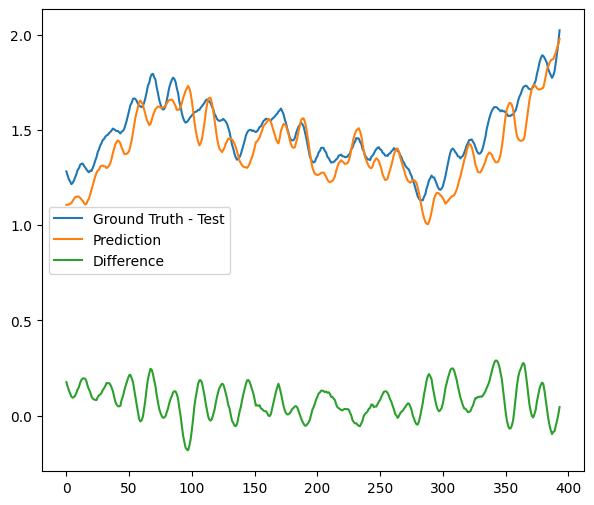

In [61]:
# Visualize
pair = 125
fix, ax = plt.subplots(figsize=(7,6))
ax.plot(test_data[10:, pair], label = 'Ground Truth - Test')
ax.plot(inverse_preds[:, pair], label = 'Prediction')
ax.plot(test_data[10:, pair]-inverse_preds[:, pair], label = 'Difference')
ax.legend()

### NCIM with mat['data']

In [6]:
# Generate NCIM Data According to Abilene Statistics 
TMncim, Tsparse, tm_real, mean_row, mean_col, sigmasq  = gen_NCIM(data=True)
print(TMncim.shape)
# Transpose TMncim (n x n x T) -> (T x n x n)
TMncim_flat = TMncim.reshape(144,-1)
TMncim_flat.shape

(12, 12, 2016)


(144, 2016)

In [15]:
from statsmodels.tsa.stattools import adfuller

stationary_list = []
p_values = []
for i in range(TMncim_flat.shape[0]): 
    time_series = TMncim_flat[i, :]
    
    # Perform ADF test
    result = adfuller(time_series)
    p_values.append(result[1])
    if result[1] <= 0.05:
        # series is stationary 
        stationary_list.append(True)
    else: 
        # series is not stationary
        stationary_list.append(False)

In [16]:
count_true = sum(1 for value in stationary_list if value is True)
count_false = sum(1 for value in stationary_list if value is False)

print("Number of Stationary Series:", count_true)   
print("Number of Non-Stationary Series:", count_false) 

Number of Stationary Series: 101
Number of Non-Stationary Series: 43


#### Do Prediction

In [33]:
# Generate NCIM Data According to Abilene Statistics 
TMncim, Tsparse, tm_real, mean_row, mean_col, sigmasq  = gen_NCIM(data=True)

# Transpose TMncim (n x n x T) -> (T x n x n)
TMncim = np.transpose(TMncim, (2,0,1))
data = TMncim.reshape(-1, 144)

print(TMncim.shape)
print(data.shape)

(2016, 12, 12)
(2016, 144)


In [37]:
# Train Test Split
data = data/1e6
train_data, test_data = train_test_split(data, 0.8)

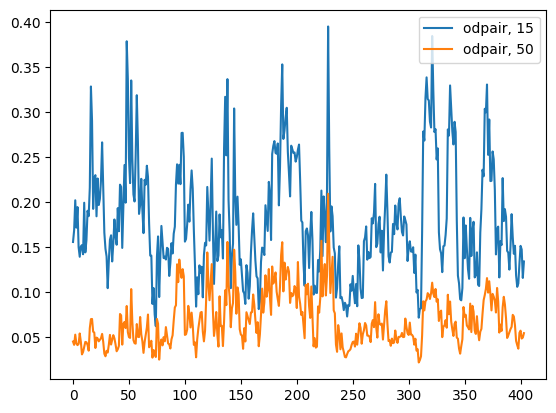

In [39]:
plt.plot(test_data[:, 15], label = 'odpair, 15')
plt.plot(test_data[:, 50], label = 'odpair, 50')
plt.legend()

In [40]:
# Min Max Normalize the train data and test data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_norm = normalize_matrix(scaler, train_data)

scaler = MinMaxScaler(feature_range=(0,1))
test_data_norm = normalize_matrix(scaler, test_data)

In [41]:
# Window the dataset 
window = 10
trainX, trainY= create_dataset(train_data_norm, window) 
testX, testY = create_dataset(test_data_norm, window) 

In [42]:
# Define hyperparameters
num_nodes = 12 
input_size = trainX.shape[2] # Number of features in input
hidden_size = 200  # Number of features in hidden state
learn_rate = 0.001 
epochs = 100
num_layers = 1
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [43]:
# Create training dataset and dataloader
train_loader = get_dataloader(trainX, trainY, batch_size, num_workers, shuffle)
test_loader = get_dataloader(testX, testY, 1, num_workers, shuffle)

In [44]:
# Create Model 
model = RNN(input_size, hidden_size, num_layers)

# Create optimizer 
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Create loss function
criterion = nn.MSELoss()

# Train the model
loss = train(model, train_loader, epochs, criterion, optimizer)

-----Begin Training------
Epoch [10/100], Loss: 7.4785e-03
Epoch [20/100], Loss: 2.4747e-03
Epoch [30/100], Loss: 1.6173e-03
Epoch [40/100], Loss: 7.8646e-04
Epoch [50/100], Loss: 4.3865e-04
Epoch [60/100], Loss: 4.4412e-04
Epoch [70/100], Loss: 2.5057e-04
Epoch [80/100], Loss: 2.9459e-04
Epoch [90/100], Loss: 2.8849e-04
Epoch [100/100], Loss: 1.5435e-04


In [45]:
# Test model
model_outputs, _ = test(model, criterion, test_loader, testY)

# Save the model 
PATH = 'models\\ncim_tm_mat_data_mse.pth'
torch.save(model.state_dict(), PATH)

# Save the model outputs 
np.save('model_outputs\\ncim_tm_mat_data_mse_outputs.npy', 
        model_outputs)

Average (Normalized) Test Loss: 2.8658e-03


In [46]:
# Plot heat maps 
plot_and_save_heatmap(test_data_norm, model_outputs, num_nodes, save_path = 'Figs\\heat_maps', 
                        fig_name = 'normalized_preds_ncim_tm_mat_data_mse.png')


# Inverse normalize model outputs
inverse_preds = inverse_normalize_predictions(test_data, model_outputs) 

plot_and_save_heatmap(test_data, inverse_preds, num_nodes, save_path = 'Figs\\heat_maps',
                          fig_name= 'inverse_normalized_model_ncim_tm_mat_data_mse.png')
    


In [47]:
def mlu_on_preds_fc(model_outputs):
    
    G = fully_connected_network(num_nodes=12, capacity=100)
    mlu_preds = np.empty((len(model_outputs), 1))

    for i in range(len(model_outputs)):

        D = model_outputs[i, :].reshape(12,12)
        np.fill_diagonal(D, 0)

        u = MinMaxLinkUtil(G, D*0.01)
        mlu_preds[i] = u

    Nans = np.any(np.isnan(mlu_preds)) # check for NaN values
    
    return mlu_preds, Nans

In [48]:
# check MLU performance 
# Compute MCF on inverse normalized predictions
mlu_preds, Nans = mlu_on_preds_fc(inverse_preds)

# Compute MCF on actual predictions 
mlu_gt_test, Nans = mlu_on_preds_fc(test_data)

np.save('mlu_outputs\\mlu_ncim_mat_data_mse.npy', mlu_preds)
np.save('mlu_outputs\\mlu_gt_test_mat_data.npy', mlu_gt_test)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-10


In [49]:
plot_and_save_ecdf(mlu_gt_test, mlu_preds, save_path = 'Figs\\ecdfs', fig_name='CDF_mlu_ncim_tm_mat_data_mse.png')
plot_and_save_mlu_compare(mlu_gt_test, mlu_preds, save_path='Figs\\mlu_compare', fig_name='mlu_compare_nicm_tm_mat_data_mse.png')
plot_and_save_pdf(mlu_gt_test, mlu_preds, save_path = 'Figs\\pdfs', fig_name='PDF_mlu_ncim_tm_mat_data_mse.png')